In [1]:
!apt-get update
!apt-get install -y nvidia-cuda-toolkit
!pip install opencv-python

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,374 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,083 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis

In [4]:
%%writefile grayscale.cu

#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>

#define CHANNELS 3

__global__
void colorConvertToGray(unsigned char *rgb, unsigned char *gray, int rows, int cols) {
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;

    if (col < cols && row < rows) {
        int gray_offset = row * cols + col;
        int rgb_offset = gray_offset * CHANNELS;

        unsigned char r = rgb[rgb_offset];
        unsigned char g = rgb[rgb_offset + 1];
        unsigned char b = rgb[rgb_offset + 2];

        gray[gray_offset] = 0.299f * r + 0.587f * g + 0.114f * b;
    }
}

void loadImageFile(unsigned char **rgb_image, int *rows, int *cols, const std::string &file) {
    cv::Mat img = cv::imread(file, cv::IMREAD_COLOR);
    if (img.empty()) {
        fprintf(stderr, "Error: Unable to load image %s\n", file.c_str());
        exit(EXIT_FAILURE);
    }

    *rows = img.rows;
    *cols = img.cols;

    *rgb_image = (unsigned char*) malloc(*rows * *cols * CHANNELS * sizeof(unsigned char));
    memcpy(*rgb_image, img.data, *rows * *cols * CHANNELS * sizeof(unsigned char));
}

void saveImageFile(const unsigned char *gray_image, int rows, int cols, const std::string &file) {
    cv::Mat img(rows, cols, CV_8UC1, (void*)gray_image);
    cv::imwrite(file, img);
}

int main() {
    std::string input_file = "input.jpg";
    std::string output_file = "output.jpg";

    unsigned char *h_rgb_image, *h_gray_image;
    unsigned char *d_rgb_image, *d_gray_image;
    int rows, cols;

    loadImageFile(&h_rgb_image, &rows, &cols, input_file);

    size_t image_size = rows * cols * CHANNELS * sizeof(unsigned char);
    size_t gray_image_size = rows * cols * sizeof(unsigned char);

    h_gray_image = (unsigned char*) malloc(gray_image_size);

    cudaMalloc(&d_rgb_image, image_size);
    cudaMalloc(&d_gray_image, gray_image_size);

    cudaMemcpy(d_rgb_image, h_rgb_image, image_size, cudaMemcpyHostToDevice);

    dim3 dimBlock(16, 16);
    dim3 dimGrid((cols + dimBlock.x - 1) / dimBlock.x, (rows + dimBlock.y - 1) / dimBlock.y);

    colorConvertToGray<<<dimGrid, dimBlock>>>(d_rgb_image, d_gray_image, rows, cols);
    cudaDeviceSynchronize();

    cudaMemcpy(h_gray_image, d_gray_image, gray_image_size, cudaMemcpyDeviceToHost);

    saveImageFile(h_gray_image, rows, cols, output_file);

    cudaFree(d_rgb_image);
    cudaFree(d_gray_image);
    free(h_rgb_image);
    free(h_gray_image);

    return 0;
}


Overwriting grayscale.cu


In [5]:
!nvcc -o grayscale grayscale.cu `pkg-config --cflags --libs opencv4`
!./grayscale

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

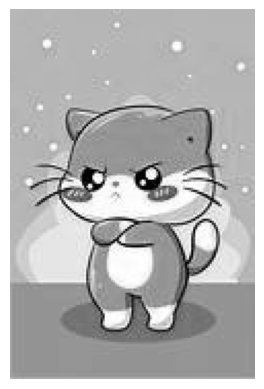

In [6]:
import cv2
from matplotlib import pyplot as plt

output_image = cv2.imread('output.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()